# EPL Machine Learning Walkthrough

## 01. Data Acquisition & Exploration
Welcome to the first part of this Machine Learning Walkthrough. This tutorial will be made of two parts; how we actually acquired our data (programmatically) and exploring the data to find potential features to use in the [next tutorial]('02. Data Preparation & Feature Engineering Tutorial').

### Data Acquisition
We will be grabbing our data from [football-data.co.uk](http://www.football-data.co.uk/englandm.php), which has an enormous amount of soccer data dating back to the 90s. They also generously allow us to use it for free! However, the data is in separate CSVs based on the season. That means we would need to manually download 20 different files if we wanted the past 20 seasons. Rather than do this laborious and boring task, let's create a function which downloads the files for us, and appends them all into one big CSV.

To do this, we will use BeautifulSoup, a Python library which helps to pull data from HTML and XML files. We will then define a function which collates all the data for us into one DataFrame.

In [66]:
# Import Modules

import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from data_preparation_functions import *

In [295]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("http://www.football-data.co.uk/englandm.php")
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')
    
    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]

    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]

    data_urls = []
    
    # Create a list of links
    prefix = 'http://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])

    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-12]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]
        
        print(f"Getting data for season {season}")
        
        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season
        
        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())
        
        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)
    
    # Drop all NAs
    df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")
    
    return df

In [296]:
df = grab_epl_data()
# df.to_csv("epl_data.csv", headers=False)

Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Getting data for season 0506
Finished grabbing data.


Whenever we want to update our data (for example if we want the most recent Gameweek included), all we have to do is run that function and then save the data to a csv with the commented out line above.

### Data Exploration
Now that we have our data, let's explore it. Let's first look at home team win rates since 2005 to see if there is a consistent trend. To get an idea of what our data looks like, we'll look at the tail of the dataset first.

In [316]:
df.tail(3)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,LBA,LBD,LBH,Month,Referee,VCA,VCD,VCH,Year,season
28,3.0,11.0,0.0,9.0,3.0,2.0,Crystal Palace,3.00,3.25,2.60,2.95,3.1,2.55,42.0,20.0,-0.25,1.71,2.13,2.92,1.73,2.16,3.22,2.55,1.79,2.21,3.04,1.77,2.23,3.36,2.66,39.0,2018-08-26,26,E0,1.0,2.0,H,6.0,14.0,0.0,13.0,5.0,0.0,0.0,D,4.0,Watford,2.95,3.20,2.50,2.90,3.1,2.50,08,A Taylor,2.90,3.3,2.6,18,1819
27,5.0,8.0,0.0,15.0,3.0,1.0,Chelsea,1.66,4.00,5.75,1.67,3.8,5.25,42.0,22.0,1.00,1.92,1.88,1.67,2.18,1.71,3.90,5.25,2.01,1.95,1.71,2.28,1.76,4.17,5.75,40.0,2018-08-26,26,E0,2.0,1.0,A,4.0,16.0,0.0,6.0,2.0,0.0,0.0,D,3.0,Newcastle,1.70,3.75,5.00,1.67,3.8,5.25,08,P Tierney,1.67,4.0,5.5,18,1819
26,4.0,8.0,0.0,12.0,2.0,1.0,Burnley,4.33,3.40,2.00,4.00,3.3,2.00,39.0,20.0,-0.25,1.65,2.22,4.14,2.22,1.69,3.36,1.98,1.72,2.31,4.50,2.32,1.74,3.57,2.04,36.0,2018-08-26,26,E0,2.0,4.0,H,6.0,11.0,0.0,25.0,12.0,2.0,3.0,H,2.0,Fulham,4.10,3.35,1.97,3.90,3.2,2.00,08,D Coote,4.33,3.4,2.0,18,1819


In [317]:
# Create Home Win, Draw Win and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

#### Home Ground Advantage

In [318]:
win_rates = \
(df.groupby('season')
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']])

win_rates

,homeWin,draw,awayWin
season,,,
0506,0.505263,0.202632,0.292105
0607,0.477573,0.258575,0.263852
0708,0.463158,0.263158,0.273684
0809,0.453826,0.255937,0.290237
0910,0.507895,0.252632,0.239474
1011,0.471053,0.292105,0.236842
1112,0.450000,0.244737,0.305263
1213,0.433862,0.285714,0.280423
1314,0.472973,0.208108,0.318919


#### Findings
As we can see, winrates across home team wins, draws and away team wins are very consistent. It seems that the home team wins around 46-47% of the time, the draw happens about 25% of the time, and the away team wins about 27% of the time. Let's plot this DataFrame so that we can see the trend more easily.

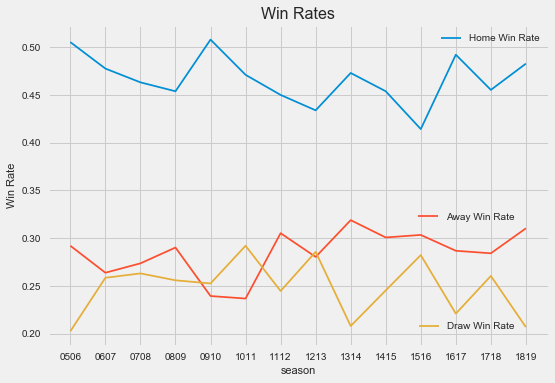

In [300]:
# Set the style
plt.style.use('seaborn-notebook')

fig = plt.figure()
ax = fig.add_subplot(111)


home_line = ax.plot(win_rates.homeWin, label='Home Win Rate')
away_line = ax.plot(win_rates.awayWin, label='Away Win Rate')
draw_line = ax.plot(win_rates.draw, label='Draw Win Rate')
ax.set_xlabel("season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.4))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.95, 0.06))

As we can see, the winrates are relatively stable each season, except for in 14/15 when the home win rate drops dramatically.

Out of interest, let's also have a look at which team has the best home ground advantage. Let's define HGA as home win rate - away win rate. And then plot some of the big clubs' HGA against each other.

In [322]:
home_win_rates = \
(df.groupby(['HomeTeam'])
    .homeWin
    .mean())

away_win_rates = \
(df.groupby(['AwayTeam'])
    .awayWin
    .mean())

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)

In [323]:
hga.head(10)

,HomeTeam,HGA
15,Fulham,0.315573
7,Brighton,0.304762
20,Man City,0.244980
14,Everton,0.241935
30,Stoke,0.241131
10,Charlton,0.236842
0,Arsenal,0.236140
27,Reading,0.234962
33,Tottenham,0.222672
21,Man United,0.218623


So the club with the best HGA is Fulham - interesting. This is most likely because Fulham have won 100% of home games in 2018 so far which is skewing the mean. Let's see how the HGA for some of the big clubs based compare over seasons.

In [357]:
big_clubs = ['Liverpool', 'Man City', 'Man United', 'Chelsea', 'Arsenal']
home_win_rates_5 = df[df.HomeTeam.isin(big_clubs)].groupby(['HomeTeam', 'season']).homeWin.mean()
away_win_rates_5 = df[df.AwayTeam.isin(big_clubs)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United
season,,,,,
0506,0.421053,0.368421,0.263158,0.263158,0.052632
0607,0.263158,0.000000,0.421053,-0.052632,0.105263
0708,0.210526,-0.052632,0.157895,0.368421,0.368421
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526
0910,0.368421,0.368421,0.421053,0.315789,0.263158
1011,0.157895,0.368421,0.368421,0.263158,0.684211
1112,0.157895,0.315789,-0.105263,0.421053,0.105263
1213,0.052632,0.105263,0.105263,0.248538,0.201754
1314,0.143275,0.251462,0.307018,0.362573,-0.026316


Now let's plot it.

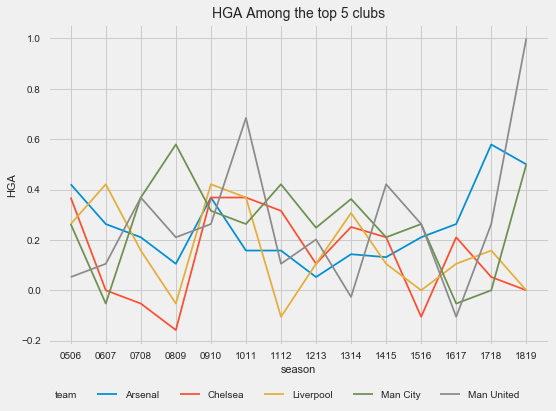

In [387]:
sns.lineplot(x='season', y='HGA', hue='team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'HomeTeam': 'team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)
plt.show()

The results here seem to be quite erratic, although it seems that Arsenal consistently has a HGA above 0.

Let's now look at the distributions of each of our columns. The odds columns are likely to be highly skewed, so we may have to account for this later.

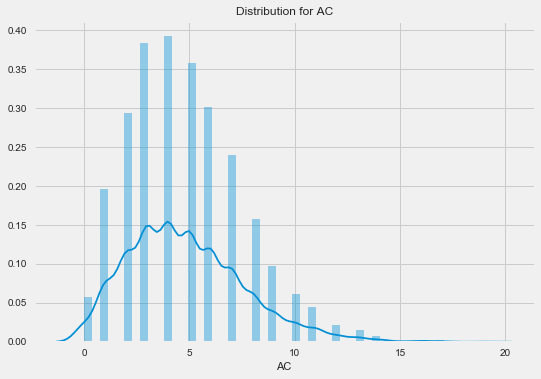

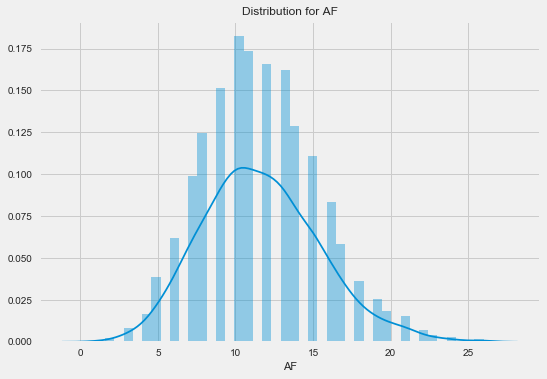

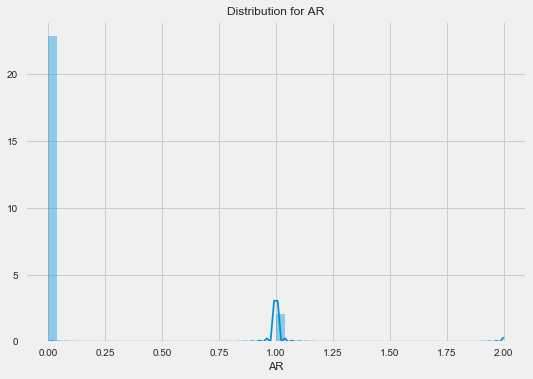

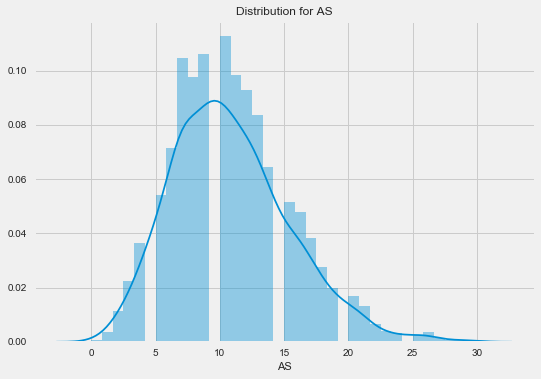

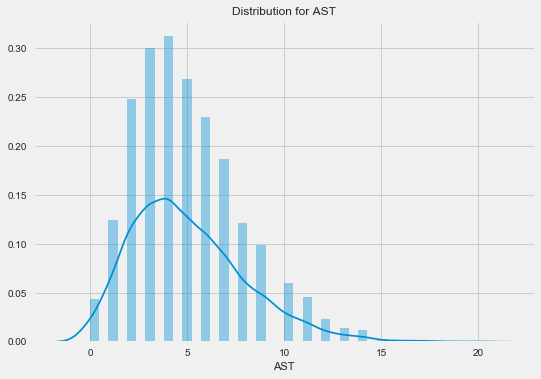

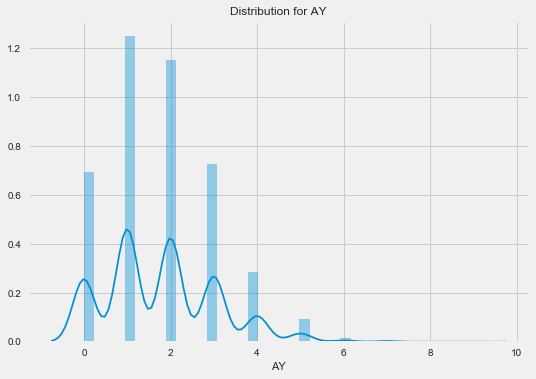

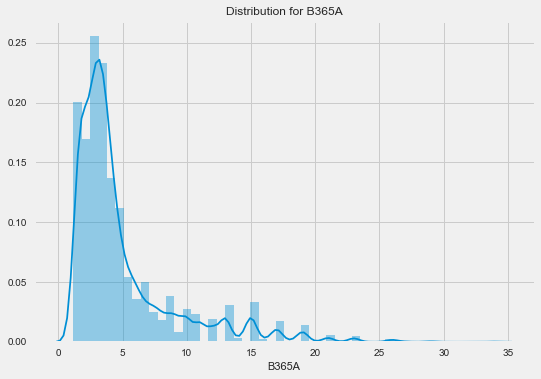

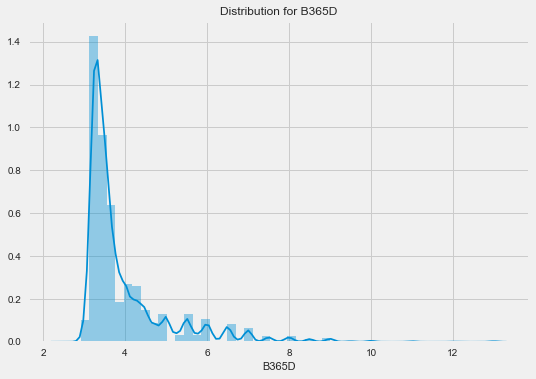

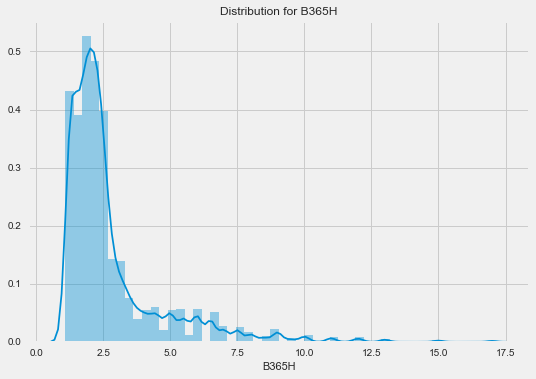

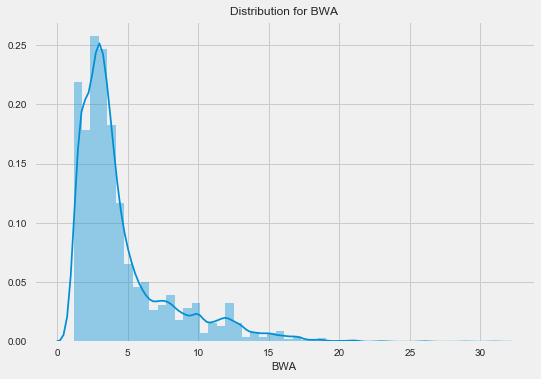

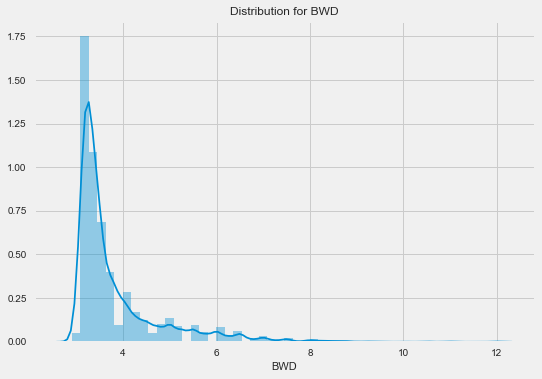

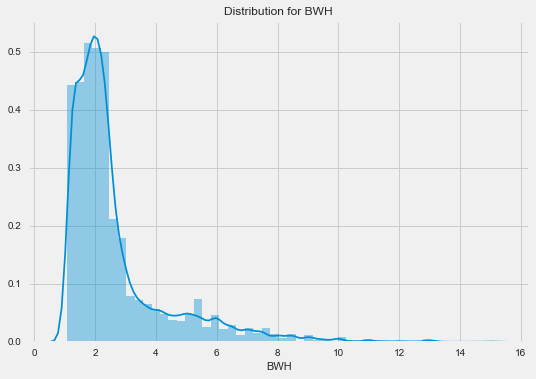

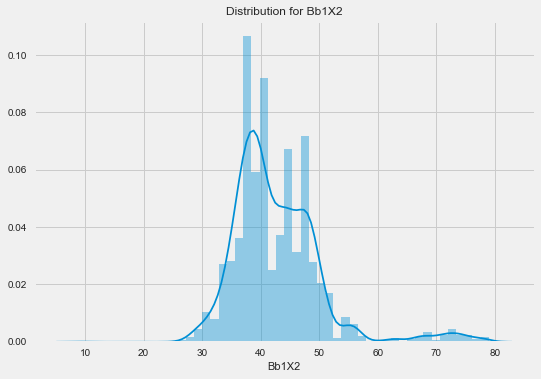

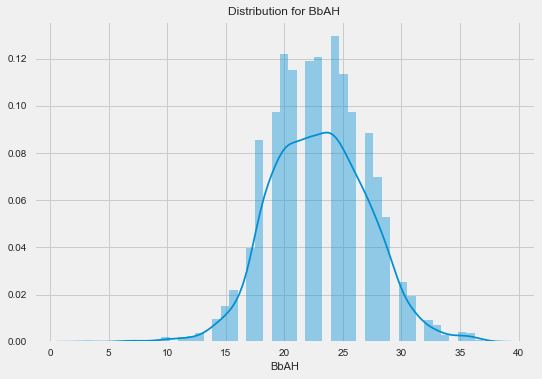

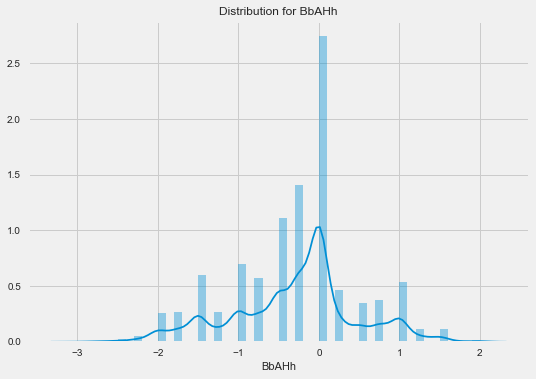

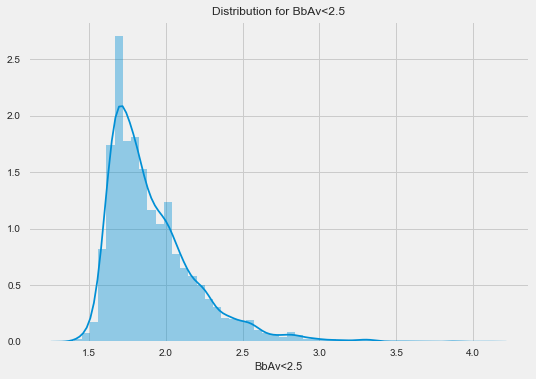

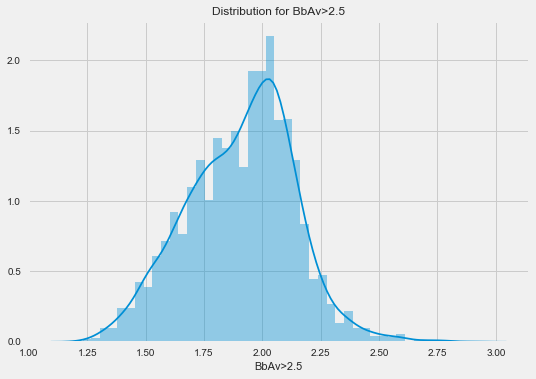

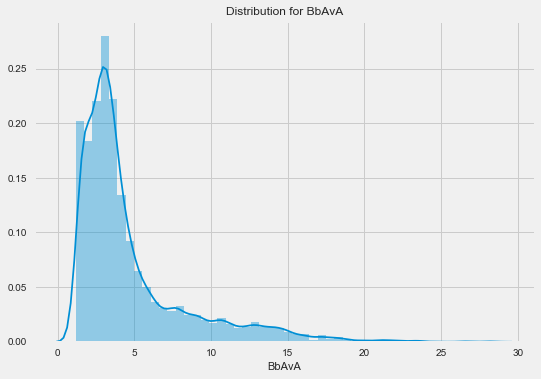

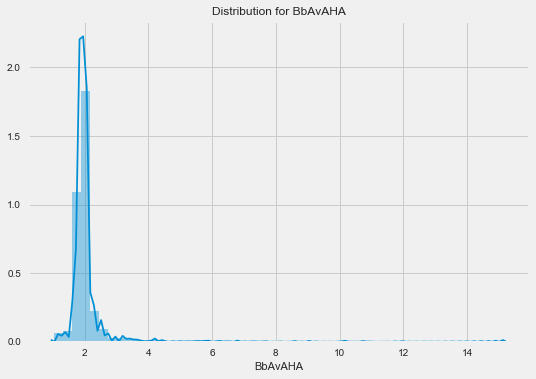

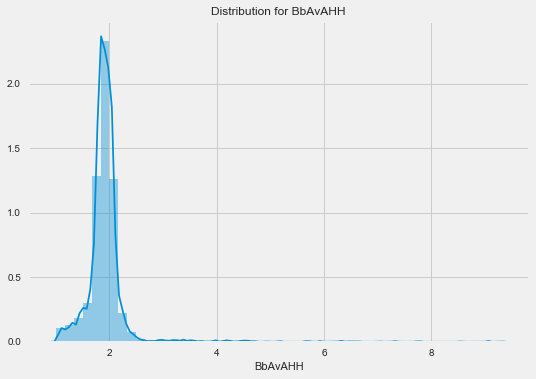

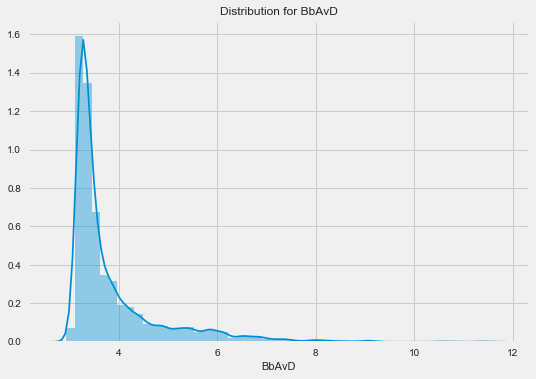

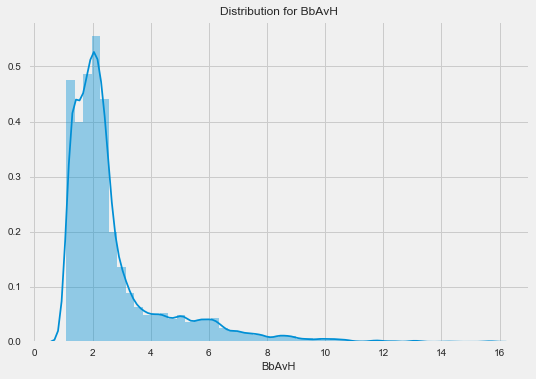

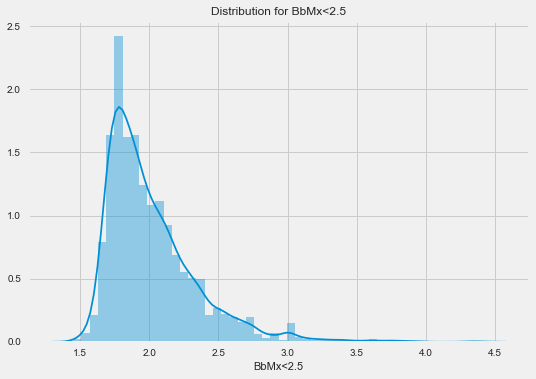

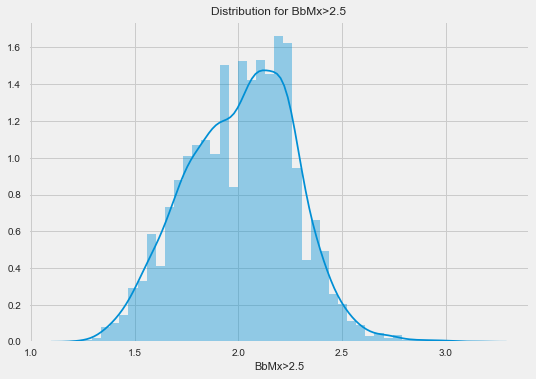

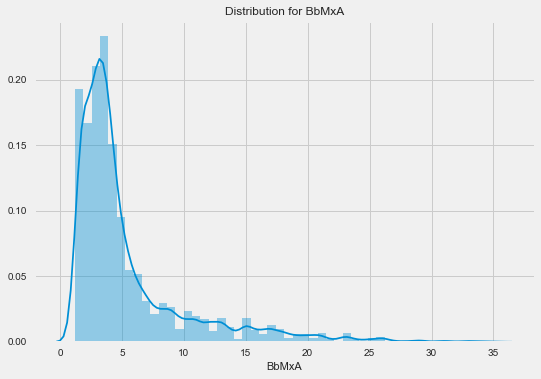

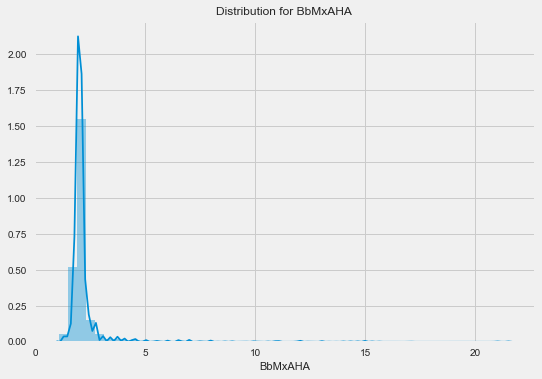

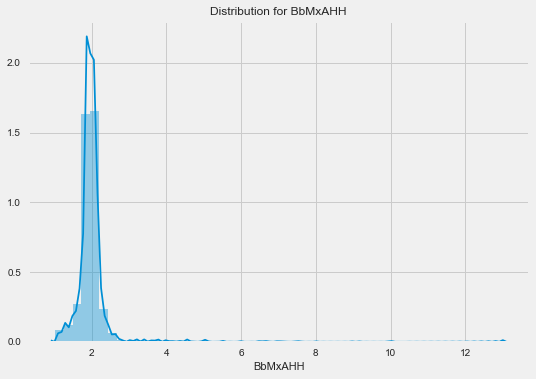

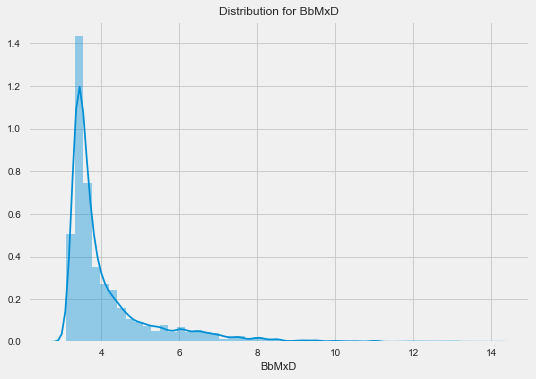

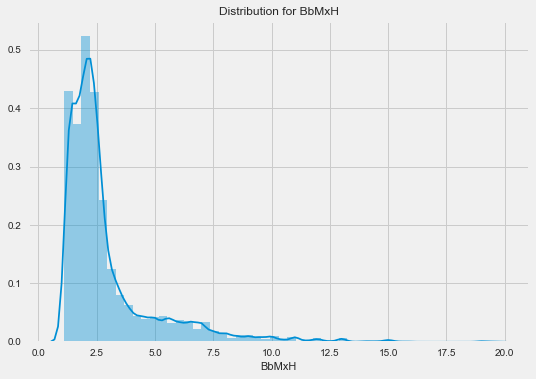

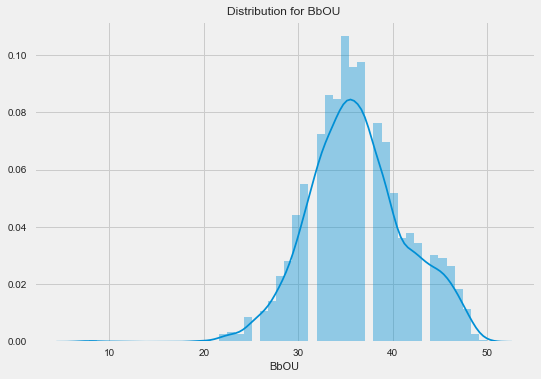

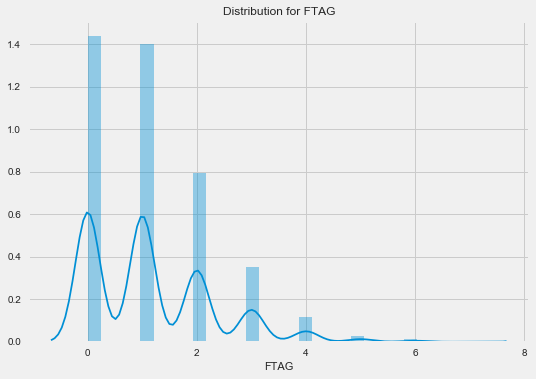

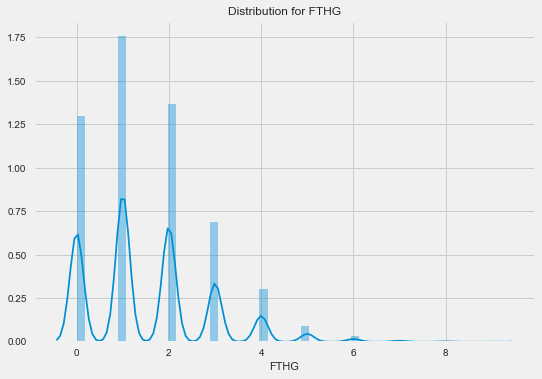

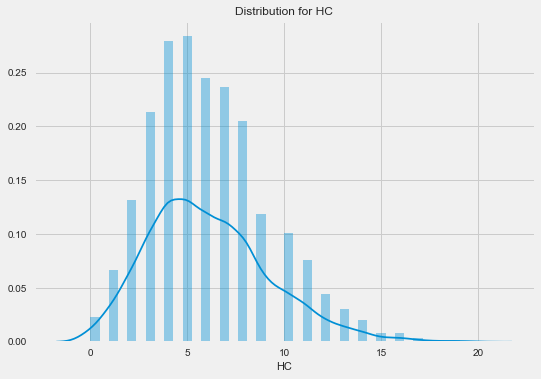

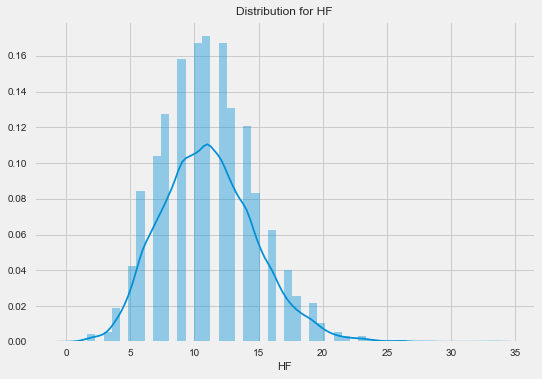

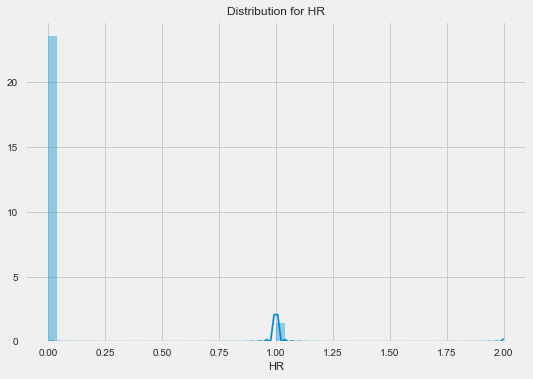

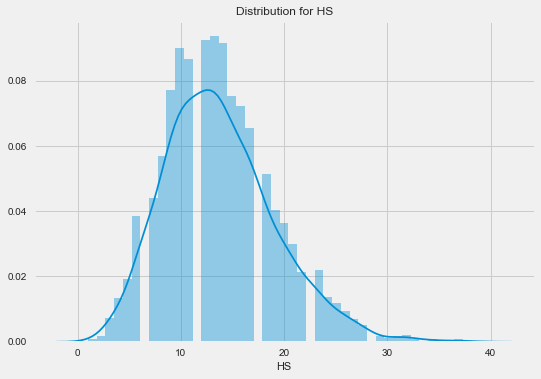

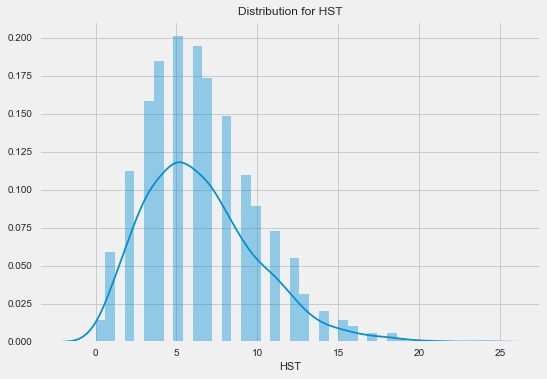

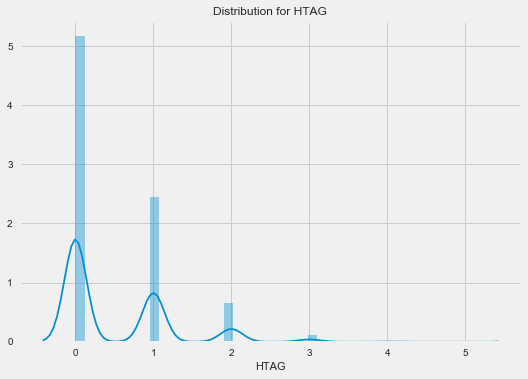

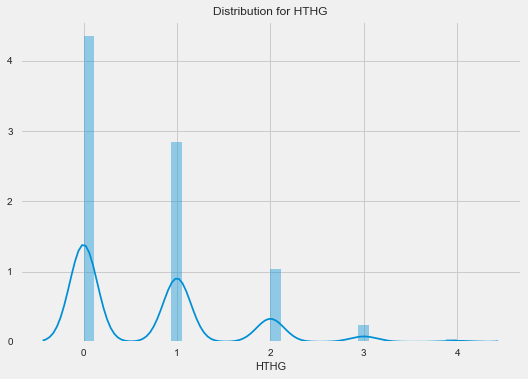

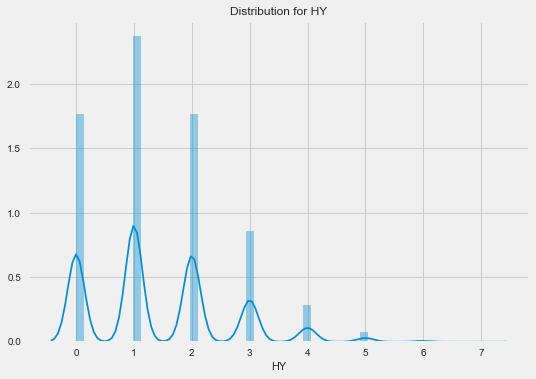

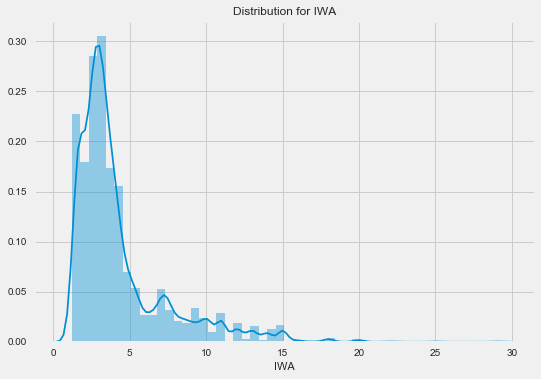

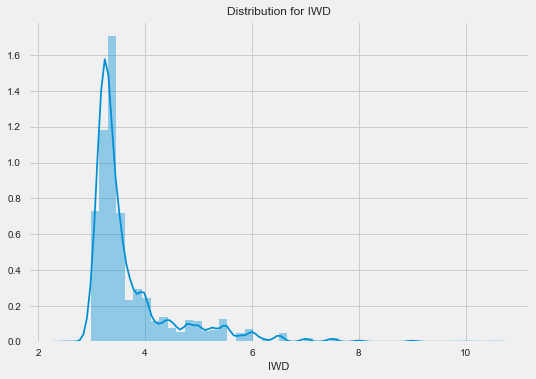

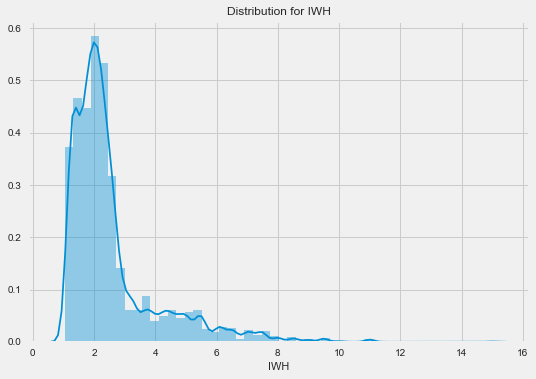

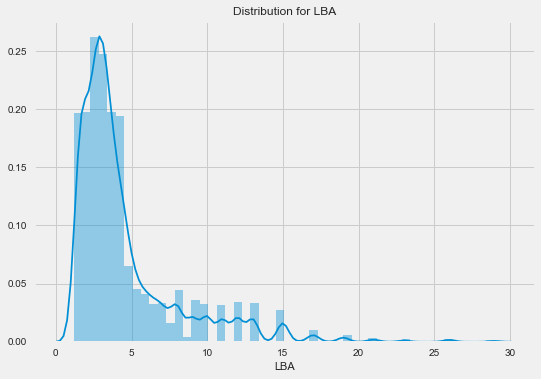

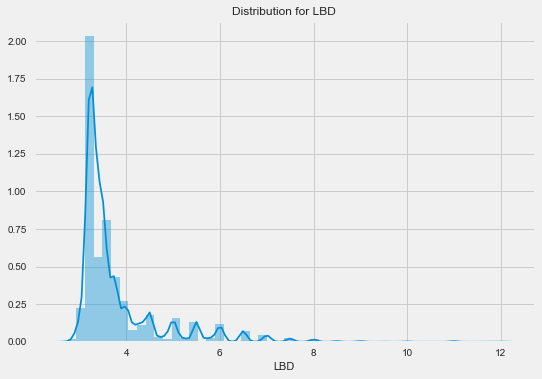

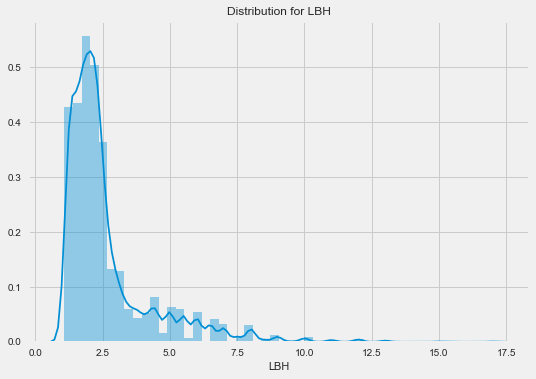

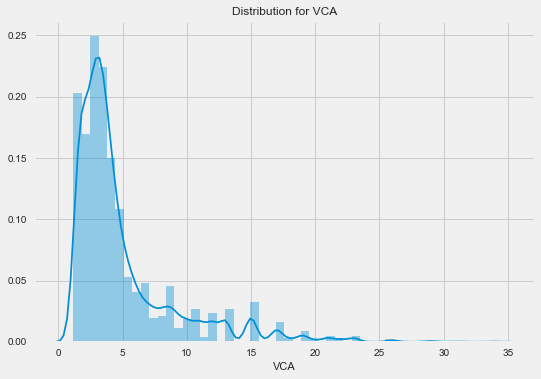

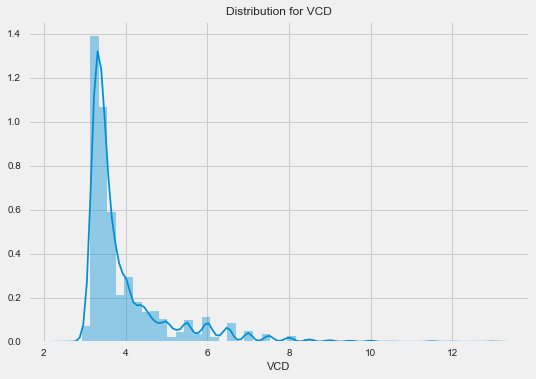

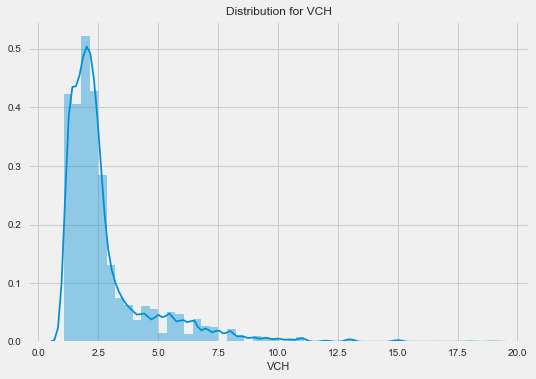

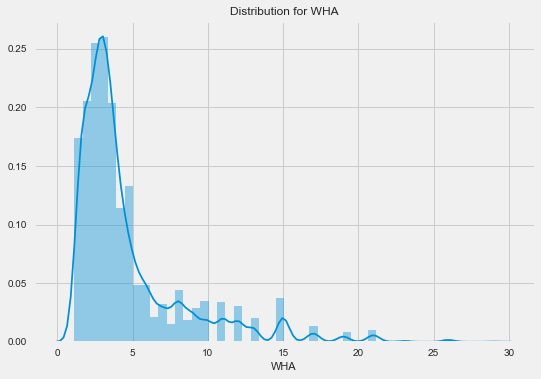

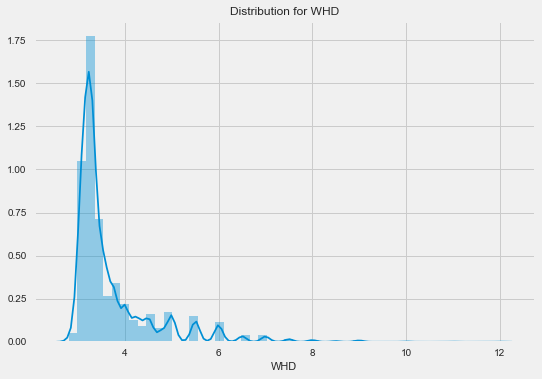

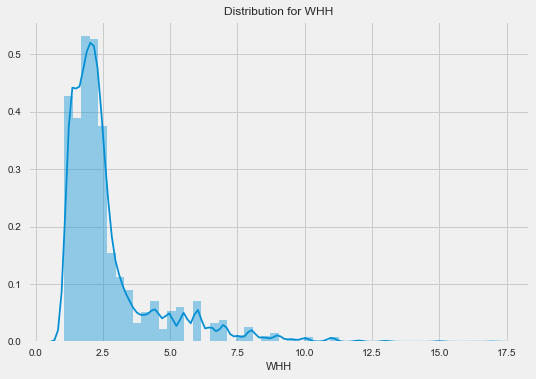

In [202]:
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution for {col}")
    plt.show()

### Exploring Referee Home Ground Bias
What may be of interest is whether certain referees are correlated with the home team winning more often. Let's explore referee home ground bias for referees for the top 10 Referees based on games.

In [427]:
print('Overall Home Win Rate: {:.4}%'.format(df.homeWin.mean() * 100))

# Get the top 10 refs based on games
top_10_refs = df.Referee.value_counts().head(10).index

df[df.Referee.isin(top_10_refs)].groupby('Referee').homeWin.mean().sort_values(ascending=False)

Overall Home Win Rate: 46.56%


Referee
L Mason          0.510373
C Foy            0.500000
M Clattenburg    0.480000
M Jones          0.475248
P Dowd           0.469880
M Atkinson       0.469565
M Oliver         0.466019
H Webb           0.456604
A Marriner       0.455516
M Dean           0.442049
Name: homeWin, dtype: float64

It seems that L Mason may be the most influenced by the home crowd. Whilst the overall home win rate is 46.5%, the home win rate when he is the Referee is 51%. However it should be noted that this doesn't mean that he causes the win through bias. It could just be that he referees the best clubs, so naturally their home win rate is high.

### Variable Correlation With Margin
Let's now explore different variables' relationships with margin. First, we'll create a margin column, then we will pick a few different variables to look at the correlations amongst each other, using a correlation heatmap.

In [428]:
df['margin'] = df['FTHG'] - df['FTAG']

In [436]:
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = df[stat_cols].corr()
stat_correlations['margin'].sort_values()

AST      -0.345822
AS       -0.298932
HY       -0.153684
HR       -0.129536
AC       -0.073630
HF       -0.067507
AF        0.005920
AY        0.014411
HC        0.067323
AR        0.103449
HS        0.276689
HST       0.367579
margin    1.000000
Name: margin, dtype: float64

Unsurprisingly, Home Shots on Target correlate the most with Margin, and Away Reds is also high. What is surprising is that Home Yellows has quite a strong negative correlation with margin - this may be because players will play more aggresively when they are losing to try and get the lead back, and hence receive more yellow cards.

Let's now look at the heatmap between variables.

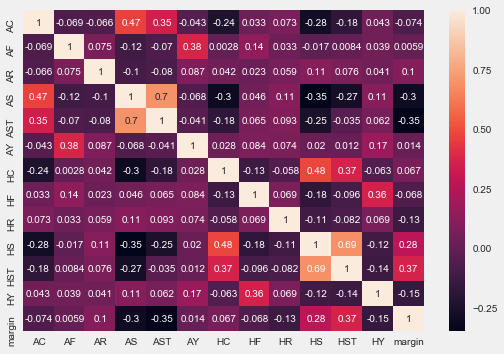

In [445]:
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 10})

### Analysing Features
What we are really interested in, is how our features (creating in the next tutorial), correlate with winning. We will skip ahead here and use a function to create our features for us, and then examine how the moving averages/different features correlate with winning.

In [454]:
# Create a cleaned df of all of our data
pre_features_df = create_df('data/epl_data.csv')

# Create our features
features = create_feature_df(pre_features_df)

Creating all games feature DataFrame


C:\Users\wardj\Documents\Betfair Public Github\Predictive-Models\EPL-Predictions-Model\data_preparation_functions.py:419: RuntimeWarning: invalid value encountered in double_scalars
  .pipe(lambda df: (df.eloAgainst * df[goalsForOrAgainstCol]).sum() / df.eloAgainst.sum()))


Creating stats feature DataFrame
Creating odds feature DataFrame
Creating market values feature DataFrame
Filling NAs
Merging stats, odds and market values into one features DataFrame
Complete.


In [455]:
features = (pre_features_df.assign(margin=lambda df: df.FTHG - df.FTAG)
                           .loc[:, ['gameId', 'margin']]
                           .pipe(pd.merge, features, on=['gameId']))

In [463]:
features.corr().margin.sort_values(ascending=False)[:20]

margin                     1.000000
f_awayOdds                 0.414372
f_totalMktH%               0.331532
f_defMktH%                 0.326223
f_eloAgainstAway           0.319941
f_eloForHome               0.319941
f_attMktH%                 0.315971
f_midMktH%                 0.314735
f_sizeOfHandicapAway       0.303696
f_goalsForHome             0.296330
f_wtEloGoalsForHome        0.293746
f_shotsForHome             0.282555
f_gkMktH%                  0.276541
f_cornersForHome           0.275852
f_wtEloGoalsAgainstAway    0.270808
f_homeWinPc38Away          0.269963
f_homeWinPc38Home          0.269963
f_cornersAgainstAway       0.258869
f_goalsAgainstAway         0.257136
f_drawOdds                 0.254074
Name: margin, dtype: float64

As we can see away odds is most highly correlated to margin. This makes sense, as odds generally have most/all information included in the price. What is interesting is that elo seems to also be highly correlated, which is good news for our elo model that we made. Similarly, weighted goals and the the value of the defence relative to other teams ('defMktH%' etc.) is strongly correlated to margin.